In [46]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
%matplotlib inline

In [2]:
#setting plottling style
plt.style.use('ggplot')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os
cwd = os.chdir(r'C:/Machine_learning_datafiles')

In [5]:
from shapely.geometry import Point, Polygon, LineString, MultiPolygon

In [6]:
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = [8,5]

In [7]:
#importing files
hourly_travel_times = pd.read_csv('./sendy_logistics/hourly_travel_times.csv')
weekly_travel_times = pd.read_csv('./sendy_logistics/weekly_travel_times.csv')
monthly_travel_times = pd.read_csv('./sendy_logistics/monthly_travel_times.csv')

In [8]:
sublocation_json = gpd.read_file('./sendy_logistics/locations/540_sublocations.json')

In [9]:
hourly_travel_times.shape

(1286035, 8)

In [10]:
weekly_travel_times.sample(4)

,sourceid,dstid,dow,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,year
200079,48,3,4,2420.75,1428.75,2176.46,1.52,2018
81430,43,87,6,1634.79,722.55,1527.66,1.42,2018
178297,11,20,7,950.22,501.55,850.17,1.59,2018
127548,92,72,1,1119.08,821.77,945.27,1.73,2018


In [11]:
monthly_travel_times.sample(4)

,sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time,year
123067,78,43,1,1371.05,537.12,1311.80,1.32,2019
32867,45,18,5,3381.04,1189.37,3172.89,1.44,2018
65170,26,61,9,335.65,301.71,282.59,1.65,2018
78907,51,90,10,2099.80,803.70,1960.22,1.44,2018


In [12]:
sublocation_json.head()

,DISPLAY_NAME,MOVEMENT_ID,geometry
0,Kiwanja,1,"POLYGON ((36.89859 -1.16106, 36.89934 -1.16136..."
1,Kahawa West,2,"POLYGON ((36.89445 -1.16934, 36.89481 -1.16969..."
2,Kongo Soweto,3,"POLYGON ((36.89429 -1.18202, 36.90141 -1.18339..."
3,Njathaini,4,"POLYGON ((36.89994 -1.19349, 36.90080 -1.19454..."
4,Karura,5,"POLYGON ((36.79952 -1.19554, 36.80290 -1.19732..."


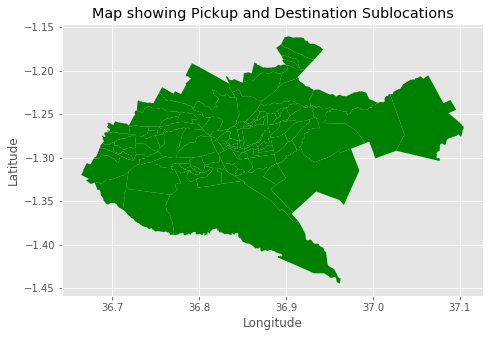

In [13]:
sublocation_json.plot(color='g')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map showing Pickup and Destination Sublocations');

In [14]:
#importing the training and test data
train = pd.read_csv('./sendy_logistics/train.csv')
test = pd.read_csv('./sendy_logistics/test.csv')

In [15]:
train['hr_of_day'] = pd.to_datetime(train['Pickup - Time']).dt.hour
test['hr_of_day'] = pd.to_datetime(test['Pickup - Time']).dt.hour

train['pickup_min'] = train['hr_of_day']*60 + pd.to_datetime(train['Pickup - Time']).dt.minute
test['pickup_min'] = test['hr_of_day']*60 + pd.to_datetime(test['Pickup - Time']).dt.minute

In [16]:
from collections import defaultdict

Finding the pickup and destination cities

In [17]:
def pickup_destination_cities_list(data):
    """This groups pickup and destination coordinates and loops each of the coordinates to find coordinates in the Polygon.
    Returns the list of pickup and destination cities.
    """
    pickup_location_list = []
    pickup_lat = []
    pickup_long = []

    #grouping pickup and destination coordinates
    pickup_coords = data.groupby(['Pickup Long', 'Pickup Lat']).count().reset_index() #pickup coords
    destination_coords = data.groupby(['Destination Long', 'Destination Lat']).count().reset_index() #destination coords

    for long, lat in pickup_coords[['Pickup Long', 'Pickup Lat']].values:
        for location,polygon in sublocation_json[['DISPLAY_NAME', 'geometry']].values:
            if (Point((long,lat)).within(polygon) or polygon.contains(Point((long,lat))) or Point((long,lat)).intersects(polygon)):
                pickup_location_list.append(location) #appending the locations
                pickup_lat.append(lat)
                pickup_long.append(long)
    
    
    destination_location_list = []
    destination_long = []
    destination_lat = []
    
    for long, lat in destination_coords[['Destination Long', 'Destination Lat']].values:
        for location,polygon in sublocation_json[['DISPLAY_NAME', 'geometry']].values:
            if (Point((long,lat)).within(polygon) or polygon.contains(Point((long,lat))) or Point((long,lat)).intersects(polygon)):
                destination_location_list.append(location)
                destination_lat.append(lat)
                destination_long.append(long)
    
    return pickup_location_list, pickup_lat, pickup_long, destination_location_list, destination_lat, destination_long

In [18]:
def pickup_destination_city_df(data):
    """This creates a dataframe of the pickup and destination cities and merges them to the main data"""
    
    pickup_location_list, pickup_lat, pickup_long, destination_location_list, destination_lat, destination_long = \
    pickup_destination_cities_list(data)
    
    pickup_cities = pd.DataFrame(pickup_location_list)
    pickup_cities['pickup_long']  = pickup_long
    pickup_cities['pickup_lat'] = pickup_lat
    pickup_cities.columns = ['Pickup_city','Pickup Long', 'Pickup Lat']

    destination_cities= pd.DataFrame(destination_location_list)
    destination_cities['destination_long'] = destination_long
    destination_cities['destintion_lat'] = destination_lat
    destination_cities.columns = ['Destination_city','Destination Long', 'Destination Lat']

    #merging the pickup and destination cities to the training data
    data = pd.merge(data, destination_cities, on=['Destination Long', 'Destination Lat'], how='left')
    data= pd.merge(data, pickup_cities, on=['Pickup Long', 'Pickup Lat'], how='left')
    
    return data

In [19]:
%%time
train = pickup_destination_city_df(train)
test = pickup_destination_city_df(test)

Wall time: 2min 4s


In [20]:
print('There are {} unique pickup coordinates in the training set'.format(3694))

There are 3694 unique pickup coordinates in the training set


In [21]:
print('There are {} unique destination coordinates in the training set'.format(5348))

There are 5348 unique destination coordinates in the training set


In [22]:
print('There are %s unique pickup coordinates in the test set' %1873)

There are 1873 unique pickup coordinates in the test set


In [23]:
print('There are %s unique destination coordinates in the test set'%2644)

There are 2644 unique destination coordinates in the test set


In [24]:
print('There are {} grouped train pickup coordinates without any city encoded in the json file'.format(140))

There are 140 grouped train pickup coordinates without any city encoded in the json file


In [25]:
print('There are {} grouped train destination coordinates without any city encoded in the json file'.format(353))

There are 353 grouped train destination coordinates without any city encoded in the json file


In [26]:
print('There are {} grouped test pickup coordinates without any city encoded in the json file'.format(54))

There are 54 grouped test pickup coordinates without any city encoded in the json file


In [27]:
print('There are {} grouped test destination coordinates without any city encoded in the json file'.format(142))

There are 142 grouped test destination coordinates without any city encoded in the json file


In [28]:
print('There are {} pickup coordinates in the train dataset with no city encoded in the geojson file]'.format(353))

There are 353 pickup coordinates in the train dataset with no city encoded in the geojson file]


In [29]:
print('There are {} destination coordinates in the train dataset with no city encoded in the geojson file'.format(769))

There are 769 destination coordinates in the train dataset with no city encoded in the geojson file


In [30]:
print('There are {} pickup coordinates in the test dataset with no city encoded in the geojson file'.format(118))

There are 118 pickup coordinates in the test dataset with no city encoded in the geojson file


In [31]:
print('There are {} destination coordinates in the test dataset with no city encoded in the geojson file'.format(252))

There are 252 destination coordinates in the test dataset with no city encoded in the geojson file


In [32]:
print('Total null values for pickup and destination cities is {}'.format(train.Pickup_city.isnull().sum()+train.Destination_city.isnull().sum()))

Total null values for pickup and destination cities is 1122


In [33]:
print('Total null values for pickup and destination cities is {}'.format(test.Pickup_city.isnull().sum()+test.Destination_city.isnull().sum()))

Total null values for pickup and destination cities is 370


We will be mapping the source ids and the dst ids in the sublocation_hr data to their respective cities from the sublocation_json data

In [34]:
#creating a location map
location_map = dict(sublocation_json[['MOVEMENT_ID','DISPLAY_NAME']].values)

In [55]:
%%time
#applying the map to the hourly, weekly nd monthly travel times
hourly_travel_times['Pickup city']= hourly_travel_times.sourceid.astype('str').map(location_map)
hourly_travel_times['Destination city'] = hourly_travel_times.dstid.astype('str').map(location_map)

Wall time: 2.53 s


Grouping hourly travel times by each pickup and destination cities

In [57]:
hourly_pickup_to_dest_travel_times = hourly_travel_times[
    [
        'mean_travel_time','Pickup city','Destination city','hod'
    ]
].groupby(['Pickup city','Destination city','hod']).mean().reset_index()

Grouping the pickup and Destination cities for both the training and testing data

In [64]:
#Grouping the pickup and destination cities for both training and test data
train_pickup_dest_cities = train[
    [
        'Pickup_city', 'Destination_city','hr_of_day'
    ]
].groupby(['Pickup_city', 'Destination_city','hr_of_day']).count().reset_index()


test_pickup_dest_cities = test[
    [
        'Pickup_city', 'Destination_city','hr_of_day'
    ]
].groupby(['Pickup_city', 'Destination_city','hr_of_day']).count().reset_index()

In [60]:
train_pickup_dest_cities.shape, test_pickup_dest_cities.shape

((2056, 2), (1346, 2))

Appending hourly mean travel times to both training and test sets
<p>Firstly we will creating a list of hourly travel times and</p>
<p>Secondly, merging them to the dataframe of pickup to destination cities for both the training and test sets</p>

In [92]:
hourly_pickup_to_dest_travel_times.shape

(203352, 4)

In [91]:
train_hourly_time_travel= pd.DataFrame([pickup_city_list,destination_list, hour_of_day, mean_travel_time_list]).T
train_hourly_time_travel.columns= ['Pickup_city','Destination_city', 'hr_of_day', 'hourly_travel_time']

In [94]:
test_hourly_time_travel= pd.DataFrame([pickup_city_list,destination_list, hour_of_day, mean_travel_time_list]).T
test_hourly_time_travel.columns= ['Pickup_city','Destination_city', 'hr_of_day', 'hourly_travel_time']

In [115]:
print('For the training data there are {} pickup and destination cities without hourly time travels'.format(2155))
print('For the test data there are {} pickup and destination cities without hourly time travels'.format(718))

For the training data there are 2155 pickup and destination cities without hourly time travels
For the test data there are 718 pickup and destination cities without hourly time travels


Merging the dataframes of the grouped pickup and destination cities with their travel times to the main train and test data.

In [117]:
train = pd.merge(train, train_hourly_time_travel, on=['Pickup_city','Destination_city','hr_of_day'], how='left')
test = pd.merge(test, test_hourly_time_travel, on=['Pickup_city','Destination_city', 'hr_of_day'], how='left')

converting the modified training and testing data to csv files

In [120]:
train.to_csv(r'./sendy_logistics/train_modified.csv', index=False)
test.to_csv(r'./sendy_logistics/test_modified.csv', index=False)

<h4>Importing the modified training and test sets</h4>

In [121]:
train = pd.read_csv(r'./sendy_logistics/train_modified.csv')
test = pd.read_csv(r'./sendy_logistics/test_modified.csv')

In [122]:
train.shape, test.shape

((21201, 34), (7068, 30))

<b>Clustering</b>

For coordinates with null values we will first cluster all coordinates and group them into clusters then take the mean and standard deviations of the time travels in those clusters

Training and test data with Not null pickup and destination cities

In [123]:
train_long_lat_not_null = train[(train.Pickup_city.notnull())&(train.Destination_city.notnull())]
[['Pickup Long', 'Pickup Lat', 'Destination Long', 'Destination Lat']
]

test_long_lat_not_null = test[(test.Pickup_city.notnull())&(test.Destination_city.notnull())][
    ['Pickup Long', 'Pickup Lat','Destination Long', 'Destination Lat']
]

Training and test data with null pickup and destination cities

In [124]:
train_long_lat_null = train[~((train.Pickup_city.notnull())&(train.Destination_city.notnull()))]
[
    ['Pickup Long', 'Pickup Lat', 'Destination Long', 'Destination Lat']
]

test_long_lat_null = test[~((test.Pickup_city.notnull())&(test.Destination_city.notnull()))]
[
    ['Pickup Long', 'Pickup Lat', 'Destination Long', 'Destination Lat']
]


[['Pickup Long', 'Pickup Lat', 'Destination Long', 'Destination Lat']]

In [125]:
print('Training data with null Pickup and destination cities are {} in number while that for the testing data are {} \
in number.'.format((353+769), (118+252)))

Training data with null Pickup and destination cities are 1122 in number while that for the testing data are 370 in number.


Plotting pickup and destination coordinates (with not null and null cities)

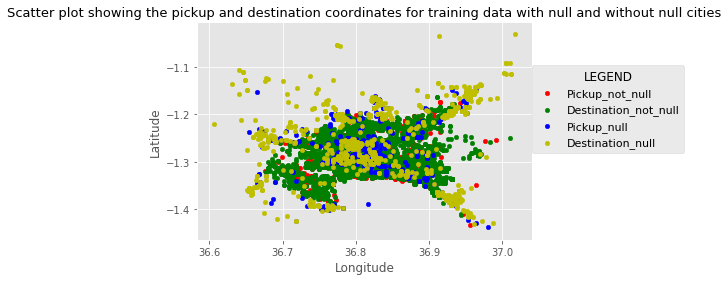

In [126]:
ax= train_long_lat_not_null[['Pickup Long','Pickup Lat']].plot.scatter(x='Pickup Long', y='Pickup Lat',c='r')

train_long_lat_not_null[['Destination Long', 'Destination Lat']].plot.scatter(
    x='Destination Long', y='Destination Lat', color='g',ax=ax)

train_long_lat_null[['Pickup Long', 'Pickup Lat']].plot.scatter(x='Pickup Long', y='Pickup Lat', c='b', ax=ax)

train_long_lat_null[['Destination Long', 'Destination Lat']].plot.scatter(x='Destination Long', y='Destination Lat', 
                                                                          color='y',ax=ax)

plt.title('Scatter plot showing the pickup and destination coordinates for \
training data with null and without null cities',fontsize=13)
plt.legend(labels=['Pickup_not_null','Destination_not_null','Pickup_null','Destination_null'], loc=[1.,0.4],ncol=1,
           fontsize=11, title='LEGEND', title_fontsize=12, fancybox=True)
plt.xlabel('Longitude')
plt.ylabel('Latitude');

In [127]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [129]:
scaler = StandardScaler()

In [130]:
%%time
cluster_list = []
silhouette_score_list= []
for cluster in range(2,30):
    kmeans = KMeans(n_clusters=cluster, random_state=3, max_iter=500, n_init=10)
    kmeans_pl = Pipeline([('scaler', scaler), ('kmeans',kmeans)])
    kmeans_pl.fit(train[['Pickup Long', 'Pickup Lat', 'Destination Long', 'Destination Lat']])
    cluster_list.append(kmeans.inertia_)
    silhouette_score_list.append(silhouette_score(train[['Pickup Long', 'Pickup Lat', 
                                                         'Destination Long', 'Destination Lat']], kmeans.labels_))

Wall time: 5min 31s


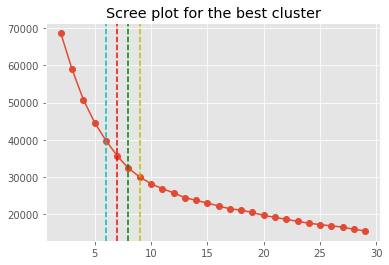

In [131]:
plt.plot(range(2,30), cluster_list, 'o-')
plt.axvline(6, color='c', ls='--')
plt.axvline(7, color='r', ls='--')
plt.axvline(8, color='g', ls='--')
plt.axvline(9, color='y', ls='--')
plt.title('Scree plot for the best cluster');

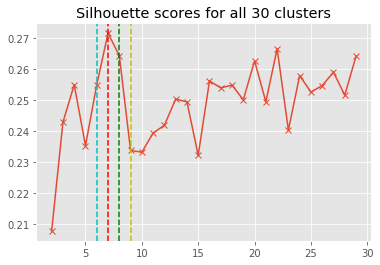

In [132]:
plt.plot(range(2,30), silhouette_score_list, 'x-')
plt.axvline(6, color='c', ls='--')
plt.axvline(7, color='r', ls='--')
plt.axvline(8, color='g', ls='--')
plt.axvline(9, color='y', ls='--')
plt.title('Silhouette scores for all 30 clusters');

From the selection we see that the best cluster groups is 7

In [133]:
kmeans = KMeans(n_clusters=7, random_state=3, max_iter=500, n_init=10)
kmeans_pl = Pipeline([('scaler', scaler), ('kmeans',kmeans)])
fit = kmeans_pl.fit(train[['Pickup Long', 'Pickup Lat', 'Destination Long', 'Destination Lat']])

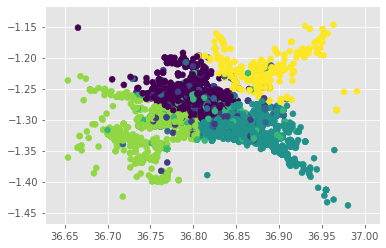

In [134]:
plt.scatter(train['Pickup Long'],  train['Pickup Lat'], c= kmeans.labels_);

In [135]:
train_cluster_gp = kmeans_pl.predict(train[['Pickup Long', 'Pickup Lat', 'Destination Long', 'Destination Lat']])
test_cluster_gp = kmeans_pl.predict(test[['Pickup Long', 'Pickup Lat', 'Destination Long', 'Destination Lat']])

In [136]:
train['cluster_gp'] = train_cluster_gp
test['cluster_gp'] = test_cluster_gp

### Filling null values

Group the coordinates by their clusters and fill in the coordinates with no cities with their mean and standard deviation travel times

<h4>Grouping the travel times by clusters</h4>

In [137]:
train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,hr_of_day,pickup_min,Destination_city,Pickup_city,hourly_travel_time,cluster_gp
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,10,627,Landmawe,South 'c',817.300000,3
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,11,704,Kenyatta,Embakasi,2106.170000,3
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,12,773,Landmawe,Landmawe,NaN,3
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,9,583,Upper Parklands,Ziwani/kariokor,1292.280000,0
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,10,605,Kilimani,Muthangari,1006.988571,0


In [138]:
train_mean_travel_times_by_cluster = train[
    ['hourly_travel_time','cluster_gp'
    ]
].groupby('cluster_gp').agg(['mean']).reset_index()


train_mean_travel_times_by_cluster.columns = ['cluster_gp','hourly_travel_time_by_cluster']

In [139]:
test_mean_travel_times_by_cluster = test[
    [
        'hourly_travel_time', 'cluster_gp'
    ]
].groupby('cluster_gp').agg(['mean']).reset_index()


test_mean_travel_times_by_cluster.columns = ['cluster_gp','hourly_travel_time_by_cluster']

In [140]:
train_mean_travel_times_by_cluster

,cluster_gp,hourly_travel_time_by_cluster
0,0,1092.468414
1,1,2029.205727
2,2,1450.780106
3,3,1573.693701
4,4,1727.736784
5,5,1392.530947
6,6,1593.660850


In [141]:
test_mean_travel_times_by_cluster

,cluster_gp,hourly_travel_time_by_cluster
0,0,1088.208672
1,1,2041.568746
2,2,1469.013113
3,3,1592.307534
4,4,1691.830483
5,5,1402.869242
6,6,1655.312762


Creating null and not null training and test sets. Then replace the hourly, weekly and monthly mean travel times with the clustered mean times. Finally, we will concatenate them to reform the training and test sets

<b>Null and non-null train hourly, weekly and monthly mean travel times</b>

training set

In [142]:
train_not_null = train[~(train.hourly_travel_time.isnull())]

train_is_null = train[(train.hourly_travel_time.isnull())]

In [144]:
cluster_list= []
hourly_mt = []
weekly_mt = []
monthly_mt = []

for (cluster_gp, hourly_travel_time) in train[
    ['cluster_gp', 'hourly_travel_time']].values:
    
    for (cluster_gp_, hourly_cluster_mean_travel_time) in train_mean_travel_times_by_cluster[
    ['cluster_gp', 'hourly_travel_time_by_cluster']
    ].values:
        
        if cluster_gp == cluster_gp_ and np.isnan(hourly_travel_time):
            hourly_mt.append(hourly_cluster_mean_travel_time)

In [145]:
len(hourly_mt)

2155

replacing the null values for the training set

In [147]:
train['hourly_travel_time'][train.hourly_travel_time.isnull()] = hourly_mt

<b>Null and Non Null hourly, weekly and monthly travel times</b>
<p>Test set</p>

In [148]:
test_is_null = test[(test.hourly_travel_time.isnull())]

test_not_null = test[~(test.hourly_travel_time.isnull())]

In [150]:
cluster_list= []
hourly_mt = []

for (cluster_gp, hourly_travel_time) in test[
    ['cluster_gp', 'hourly_travel_time']
].values:
    
    for (cluster_gp_, hourly_cluster_mean_travel_time) in test_mean_travel_times_by_cluster[
    ['cluster_gp', 'hourly_travel_time_by_cluster']
    ].values:
        
        if cluster_gp == cluster_gp_ and np.isnan(hourly_travel_time):
            hourly_mt.append(hourly_cluster_mean_travel_time)

In [151]:
#Replacing the null hourly, weekly and monthly values for test set
test['hourly_travel_time'][test.hourly_travel_time.isnull()] = hourly_mt

In [152]:
train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival,hr_of_day,pickup_min,Destination_city,Pickup_city,hourly_travel_time,cluster_gp
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745,10,627,Landmawe,South 'c',817.300000,3
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993,11,704,Kenyatta,Embakasi,2106.170000,3
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455,12,773,Landmawe,Landmawe,1727.736784,3
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341,9,583,Upper Parklands,Ziwani/kariokor,1292.280000,0
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214,10,605,Kilimani,Muthangari,1006.988571,0


In [153]:
test.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,hr_of_day,pickup_min,Destination_city,Pickup_city,hourly_travel_time,cluster_gp
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,4:44:29 PM,27,3,4:53:04 PM,27,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192,17,1026,Nairobi West,Imara Daima,932.744286,3
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,12:59:17 PM,17,5,1:20:27 PM,17,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868,13,805,Ngara East,Kileleshwa,1063.108571,0
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,11:25:05 AM,27,4,11:33:20 AM,27,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26,11,717,Airbase,City Square,1848.011429,3
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,1:53:27 PM,17,1,2:02:41 PM,17,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685,14,856,Golf Course,Kilimani,463.651429,4
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,11:34:45 AM,11,2,11:47:19 AM,11,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858,11,716,Muthangari,Kilimani,721.531429,0


Dropping the cluster group column

In [154]:
train.drop('cluster_gp', axis=1, inplace=True)
test.drop('cluster_gp', axis=1, inplace=True)

In [155]:
#saving as csv
train.to_csv('./sendy_logistics/train_cleaned.csv', index=False)
test.to_csv('./sendy_logistics/test_cleaned.csv', index=False)